# Box 6.2: Worked example of polynomial regression
Data set from Caley & Schluter (1997), examining the regression of local species richness against regional species richness just for North America and at a sampling scale of 10% of the region.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns

# Load data

In [2]:
df = pd.read_csv('../../data/chpt6/caley.csv')

In [3]:
df.head()

,TAXON,LSPP10,RSPP10
0,AMPH,6,9
1,BIRDS,187,207
2,BUTTER,103,145
3,FISH,26,36
4,MAMMALS,66,117


	* TAXON - taxanomic group
	* LSPP10 - local species richness at a sampling scale of 10% of North American region
	* RSPP10 - regional species richness at a sampling scale of 10% of North American region

### Distribution

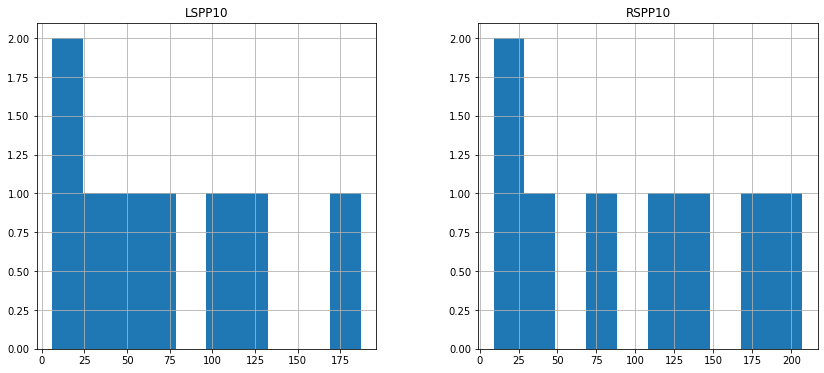

In [4]:
h = df[['LSPP10','RSPP10']].hist(figsize=(14,6))

Although there was some evidence that both local and regional species richness were skewed, we will, like the original authors, analyze untransformed variables.

# Polynomial (full) model:
First, we will ﬁt a second-order polynomial to the data:

$(local species richness)_i = \beta_0 + \beta_1(regional species richness)_i + \beta_2(regional species richness)^2_i + \epsilon_i$

In [5]:
ols_result_full = ols(formula='LSPP10~RSPP10+I(RSPP10**2)', data=df).fit()
# The I(...) basically says "patsy, please stop being clever here and just let Python handle everything inside kthx"
print(ols_result_full.summary())

                            OLS Regression Results                            
Dep. Variable:                 LSPP10   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     184.6
Date:                Sun, 05 Jan 2020   Prob (F-statistic):           2.06e-05
Time:                        17:42:30   Log-Likelihood:                -26.759
No. Observations:                   8   AIC:                             59.52
Df Residuals:                       5   BIC:                             59.76
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          8.1242      6.749      1.

C:\Users\Cami\Anaconda3\envs\stat\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


The high condiction number (4.52e+04) indicates high collinearity between regional species richness and (regional species richness)^2 as we would expect. This collinearity might affect the estimate and test of $b_1$ but won’t affect the partitioning of the variance and the calculation of $SS_{Extra}$ $[(regional species richness)^2 | regional species richness]$, so we, like Caley & Schluter (1997) will continue the analysis with uncentered data.

### ANOVA partitioning
Statsmodels **sm.stats.anova_lm** outputs:
- **sum_sq:** The SS_Extra (SS of full model minus SS with parameter omitted) for each model term. Additionally it provides the SS of Residuals)

In [6]:
anova_full = sm.stats.anova_lm(ols_result_full, typ=2)
anova_full

,sum_sq,df,F,PR(>F)
RSPP10,161.319282,1.0,2.141670,0.203216
I(RSPP10 ** 2),922.636791,1.0,12.248899,0.017287
Residual,376.620287,5.0,NaN,NaN


The $SS_{Extra}$ is 922.7 with one df and F $[(regional species richness)^2 | regional species richness]$ equals 12.249 with P < 0.018. We would conclude that adding the second-order polynomial term to this model contributes signiﬁcantly to explained variation in local species richness.

### Manual Calculation
Partial F test, to test the $H_0$ that a single partialregression slope equals zero:
- $F_{df,n-p}=\frac{MS_{Extra}}{Full MS_{Residual}}$
    -  df: the number of predictor variables in the full model minus thenumber of predictor variables in the reducedmodel. Because we only test for a single regression parameter, this will be 1 
    - p: the number of predictor variables
    - n: the number of observations

In [7]:
ols_result_reduced = ols(formula="LSPP10~RSPP10", data=df).fit()

In [8]:
# Explained / Regression sum of sqares of the full model
SS_Reg_Full = ols_result_full.ess
# Residual sum of sqares of the full model
SS_Res_Full = ols_result_full.ssr

# Explained / Regression sum of sqares of the reduced model
SS_Reg_Red = ols_result_reduced.ess
# Residual sum of sqares of the reduced model
SS_Res_Red = ols_result_reduced.ssr

print('SS_Reg_Full: {}'.format(SS_Reg_Full))
print('SS_Res_Full: {}'.format(SS_Res_Full))
print('SS_Reg_Red: {}'.format(SS_Reg_Red))
print('SS_Res_Red: {}'.format(SS_Res_Red))

SS_Reg_Full: 27806.879712622926
SS_Res_Full: 376.62028737707607
SS_Reg_Red: 26884.242921571167
SS_Res_Red: 1299.2570784288337


In [9]:
# Calculating the extra sum of sqares when comparing full with reduced model
SS_Reg_Extra = SS_Reg_Full-SS_Reg_Red
print('SS_Reg_Extra: {}'.format(SS_Reg_Extra))

SS_Reg_Extra: 922.6367910517583


In [10]:
# Convert sum of sqares to MS by dividing by df  (number of parameters full-model - number of parameters of reduced-model)
MS_Extra = SS_Reg_Extra/(ols_result_full.df_model-ols_result_reduced.df_model)
print('MS_Extra: {}'.format(MS_Extra))

MS_Extra: 922.6367910517583


In [11]:
# get the MSE of residuals
MS_Res = ols_result_full.mse_resid
print('MS_Residuals: {}'.format(MS_Res))

MS_Residuals: 75.32405747541522


In [12]:
# Calculate F-Statistics
F = MS_Extra/MS_Res
print('F: {}'.format(F))

F: 12.248899249126282


In [13]:
# Calculate probability
df1 = 1 # degree of freedom of MS_Extra. Num of param full - num of param reduced model 
df2 = 5 # degree of freedom of Residuals. (n-p-1) We have 8 observations and 2 parameters (full model) = 8-2-1=5
1-stats.f.cdf(F, 1, 5)

0.01728733948059402